In [1]:
import torch
import torch.nn as nn
import torch.optim as opt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import utils

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [2]:
torch.manual_seed(777)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(777)

In [3]:
mnist_dataset = datasets.MNIST(
    root="./data/",
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, ))
        ]
    )
)

In [4]:
BATCH_SIZE = 64
EPOCHS= 25

GENERATOR_IN_CHANNELS = 100
GENERATOR_OUT_CHANNELS = 64

DISCRIMINATOR_IN_CHANNELS = 1
DISCRIMINATOR_OUT_CHANNELS = 64

data_loader = torch.utils.data.DataLoader(
    dataset=mnist_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

In [5]:
# Output size = [(Input size - 1) * stride] - 2 * padding + kernel size

class Generator(nn.Module):
    def __init__(self, in_channels=GENERATOR_IN_CHANNELS, out_channels=GENERATOR_OUT_CHANNELS, result_channels=1):
        super().__init__()
        self.layers = nn.Sequential(
            # 512 * 4 * 4
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(out_channels * 8),
            nn.ReLU(inplace=True),
            
            # 256 * 8 * 8
            nn.ConvTranspose2d(in_channels=out_channels * 8, out_channels=out_channels * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels * 4),
            nn.ReLU(inplace=True),
            
            # 128 * 16 * 16
            nn.ConvTranspose2d(in_channels=out_channels * 4, out_channels=out_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels * 2),
            nn.ReLU(inplace=True),
            
            # 64 * 32 * 32
            nn.ConvTranspose2d(in_channels=out_channels * 2, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            # 1 * 28 * 28
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=result_channels, kernel_size=1, stride=1, padding=2),
            nn.Tanh()    
        )

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=DISCRIMINATOR_IN_CHANNELS, out_channels=DISCRIMINATOR_OUT_CHANNELS):
        super().__init__()
        self.layers = nn.Sequential(
            # 64 * 14 * 14
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 128 * 7 * 7
            nn.Conv2d(out_channels, out_channels * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 256 * 3 * 3
            nn.Conv2d(out_channels * 2, out_channels * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 1 * 1 * 1
            nn.Conv2d(out_channels * 4, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()              
        )

    def forward(self, x):
        return self.layers(x).flatten()

epoch: 1 running

        loss status
        epoch: 1/25
        geneartor loss: 10.219051361083984
        discriminator loss: 6.0470119933597744e-05
        
        


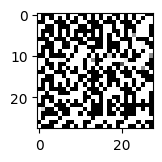

epoch: 1 terminated
epoch: 2 running

        loss status
        epoch: 2/25
        geneartor loss: 11.294300079345703
        discriminator loss: 1.9494505977490917e-05
        
        


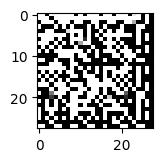

epoch: 2 terminated
epoch: 3 running

        loss status
        epoch: 3/25
        geneartor loss: 12.587270736694336
        discriminator loss: 6.569890047103399e-06
        
        


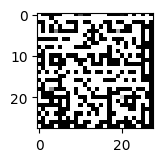

epoch: 3 terminated
epoch: 4 running

        loss status
        epoch: 4/25
        geneartor loss: 12.50495719909668
        discriminator loss: 5.768926712335087e-06
        
        


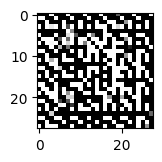

epoch: 4 terminated
epoch: 5 running

        loss status
        epoch: 5/25
        geneartor loss: 0.8929834365844727
        discriminator loss: 1.0110008716583252
        
        


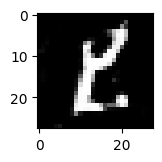

epoch: 5 terminated
epoch: 6 running

        loss status
        epoch: 6/25
        geneartor loss: 0.9626049995422363
        discriminator loss: 0.9836959838867188
        
        


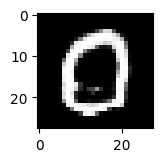

epoch: 6 terminated
epoch: 7 running

        loss status
        epoch: 7/25
        geneartor loss: 0.9407908320426941
        discriminator loss: 1.3770642280578613
        
        


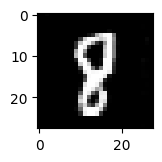

epoch: 7 terminated
epoch: 8 running

        loss status
        epoch: 8/25
        geneartor loss: 0.9677985906600952
        discriminator loss: 1.1582399606704712
        
        


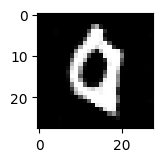

epoch: 8 terminated
epoch: 9 running

        loss status
        epoch: 9/25
        geneartor loss: 1.5549973249435425
        discriminator loss: 1.4708421230316162
        
        


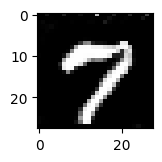

epoch: 9 terminated
epoch: 10 running

        loss status
        epoch: 10/25
        geneartor loss: 1.2064863443374634
        discriminator loss: 1.19752836227417
        
        


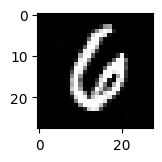

epoch: 10 terminated
epoch: 11 running

        loss status
        epoch: 11/25
        geneartor loss: 0.7701663374900818
        discriminator loss: 1.2773776054382324
        
        


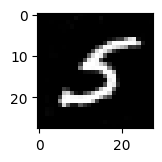

epoch: 11 terminated
epoch: 12 running

        loss status
        epoch: 12/25
        geneartor loss: 0.8155888915061951
        discriminator loss: 1.2590975761413574
        
        


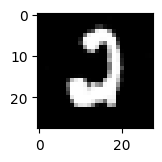

epoch: 12 terminated
epoch: 13 running

        loss status
        epoch: 13/25
        geneartor loss: 0.7728614211082458
        discriminator loss: 1.130713939666748
        
        


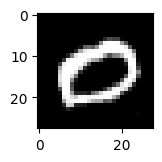

epoch: 13 terminated
epoch: 14 running

        loss status
        epoch: 14/25
        geneartor loss: 0.8618438243865967
        discriminator loss: 1.1199849843978882
        
        


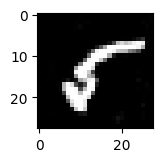

epoch: 14 terminated
epoch: 15 running

        loss status
        epoch: 15/25
        geneartor loss: 1.2689496278762817
        discriminator loss: 1.2502927780151367
        
        


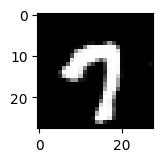

epoch: 15 terminated
epoch: 16 running

        loss status
        epoch: 16/25
        geneartor loss: 1.1243443489074707
        discriminator loss: 1.2355732917785645
        
        


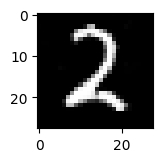

epoch: 16 terminated
epoch: 17 running

        loss status
        epoch: 17/25
        geneartor loss: 1.0158615112304688
        discriminator loss: 1.0145193338394165
        
        


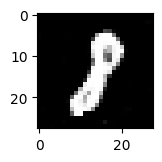

epoch: 17 terminated
epoch: 18 running

        loss status
        epoch: 18/25
        geneartor loss: 0.7370868921279907
        discriminator loss: 1.005661964416504
        
        


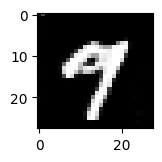

epoch: 18 terminated
epoch: 19 running

        loss status
        epoch: 19/25
        geneartor loss: 1.1863443851470947
        discriminator loss: 1.3344274759292603
        
        


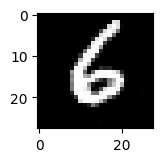

epoch: 19 terminated
epoch: 20 running

        loss status
        epoch: 20/25
        geneartor loss: 1.1946649551391602
        discriminator loss: 1.1026381254196167
        
        


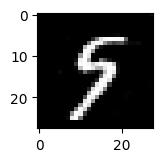

epoch: 20 terminated
epoch: 21 running

        loss status
        epoch: 21/25
        geneartor loss: 0.9528669714927673
        discriminator loss: 0.9480625987052917
        
        


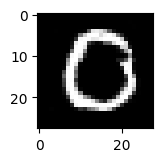

epoch: 21 terminated
epoch: 22 running

        loss status
        epoch: 22/25
        geneartor loss: 0.5878185033798218
        discriminator loss: 0.950404167175293
        
        


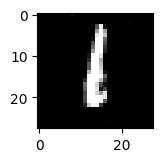

epoch: 22 terminated
epoch: 23 running

        loss status
        epoch: 23/25
        geneartor loss: 0.9548801779747009
        discriminator loss: 0.7746740579605103
        
        


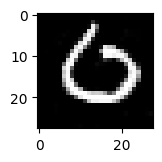

epoch: 23 terminated
epoch: 24 running

        loss status
        epoch: 24/25
        geneartor loss: 0.9220973253250122
        discriminator loss: 1.1525604724884033
        
        


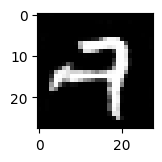

epoch: 24 terminated
epoch: 25 running

        loss status
        epoch: 25/25
        geneartor loss: 1.7801380157470703
        discriminator loss: 1.1082792282104492
        
        


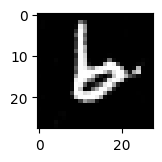

epoch: 25 terminated


In [43]:
generator = Generator()
generator.cuda()
generator_optimizer = opt.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator = Discriminator()
discriminator.cuda()
discriminator_optimizer = opt.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

loss_function = nn.BCELoss()

EPOCHS = 25

for epoch in range(1, EPOCHS + 1):
    print(f"epoch: {epoch} running")
    
    for x, _ in data_loader:
        
        real_x = x.cuda()
        batch_size = x.shape[0]
        
        outputs = discriminator(real_x)
        label_real = torch.ones(batch_size).cuda()
        discriminator_loss_real = loss_function(outputs, label_real)
        
        noise = torch.randn(batch_size, GENERATOR_IN_CHANNELS, 1, 1).cuda()
        fake_x = generator(noise)
        
        outputs = discriminator(fake_x)
        label_fake = torch.zeros(batch_size).cuda()
        discriminator_loss_fake = loss_function(outputs, label_fake)
        
        discriminator_loss = discriminator_loss_real + discriminator_loss_fake
        
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        noise = torch.randn(batch_size, GENERATOR_IN_CHANNELS, 1, 1).cuda()
        fake_x = generator(noise)
        outputs = discriminator(fake_x)
        
        generator_loss = loss_function(outputs, label_real)
        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
        
    print(
        f"""
        loss status
        epoch: {epoch}/{EPOCHS}
        geneartor loss: {generator_loss.item()}
        discriminator loss: {discriminator_loss.item()}
        
        """
    )
    
    with torch.no_grad():
        eval_noise = torch.randn(1, GENERATOR_IN_CHANNELS, 1, 1).cuda()
        eval_x = generator(eval_noise)
        
        utils.imshow(eval_x.reshape(1, -1))
    
    print(f"epoch: {epoch} terminated")
    

In [52]:
generator

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (13): Tanh()
  )
)

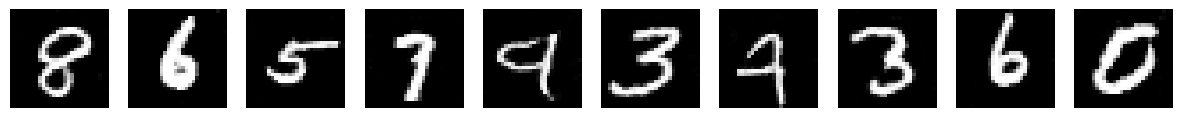

In [64]:

with torch.no_grad():
    eval_noise = torch.randn(10, GENERATOR_IN_CHANNELS, 1, 1).cuda()
    eval_x = generator(eval_noise)
    
    utils.grid_imshow(eval_x.reshape(10, -1))